# Exercise 1 Task 1 Comparing linear and non-linear DR

**Jussi Juvonen**
**27.10.2025**

**Task**: Visualize MNIST-784 handwritten digits dataset with SOM and discuss what you can learn
from the visualization.

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from minisom import MiniSom
from scipy.io import arff
from collections import defaultdict

In [21]:
data_path = os.path.join('data', 'mnist_784.arff')

data, meta = arff.loadarff(data_path)
df = pd.DataFrame(data)

for c in df.columns:
    first_non_null = None
    for v in df[c].values:
        if v is not None:
            first_non_null = v
            break
    
    if isinstance(first_non_null, (bytes, bytearray, np.bytes_)):
        df[c] = df[c].apply(lambda x: x.decode() if isinstance(x, (bytes, bytearray, np.bytes_)) else x)

print('Shape:', df.shape)
display(df.head())

features = df.iloc[:, :-1]
total_elements = features.size
nonzero_elements = (features != 0).sum().sum()
print(f'Total elements: {total_elements:}')
print(f'Non-zero elements: {nonzero_elements:}')
print(f'Percentage of non-zero values: {100 * nonzero_elements / total_elements:.2f}%')

max_val = features.to_numpy().max()
min_val = features.to_numpy().min()
print(f'Max val: {max_val}')
print(f'Min val: {min_val}')


Shape: (70000, 785)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


Total elements: 54880000
Non-zero elements: 10505375
Percentage of non-zero values: 19.14%
Max val: 255.0
Min val: 0.0


In [22]:
cols = df.columns.tolist()
feature_cols = cols[:-1]
label_col = cols[-1]
y = df[label_col].astype(str).values

X = df[feature_cols].astype(float).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
use_all = False
n_samples = 2500

if use_all:
    X_use = X_scaled
    y_use = y
else:
    rng = np.random.RandomState(0)
    idx = rng.choice(np.arange(X_scaled.shape[0]), size=n_samples, replace=False)
    X_use = X_scaled[idx]
    y_use = y[idx] if y is not None else None

# Check how many of each digit are present
unique, counts = np.unique(y_use, return_counts=True)
digit_counts = dict(zip(unique, counts))
digits = [str(d) for d in range(10)]

pd.DataFrame({'Digit': digits, 'Count': [digit_counts.get(d, 0) for d in digits]})

,Digit,Count
0,0,260
1,1,279
2,2,259
3,3,223
4,4,239
5,5,204
6,6,241
7,7,278
8,8,261
9,9,256


In [24]:
# Create and train SOM
som_x, som_y = 20, 20
input_len = X_use.shape[1]
sigma = 1.0
lr = 0.5
n_iter = 200

som = MiniSom(som_x, som_y, input_len, sigma=sigma, learning_rate=lr, random_seed=0)
som.pca_weights_init(X_use)
som.train_random(X_use, n_iter)
print('SOM training finished.')

c:\Users\jussi\OneDrive\Työpöytä\koulu\a DI\Y2\ADAaML\ADAaML_p2\.venv\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


SOM training finished.


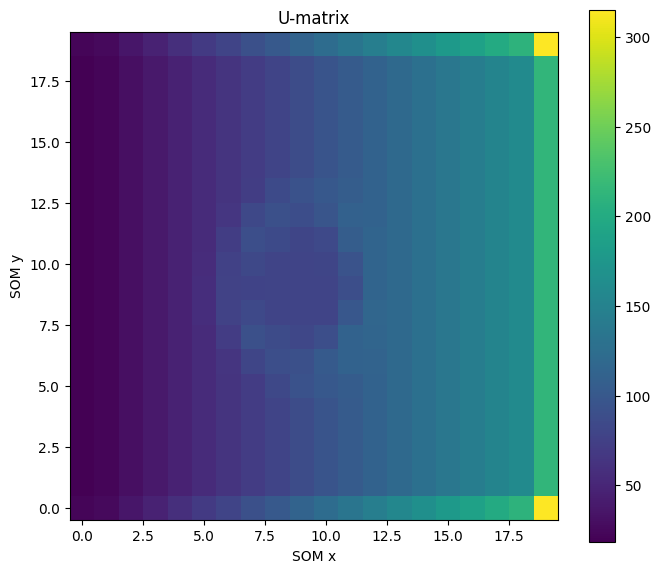

In [25]:
def compute_u_matrix(som):
    m, n = som.get_weights().shape[:2]
    u = np.zeros((m, n))
    weights = som.get_weights()
    for i in range(m):
        for j in range(n):
            neighs = []
            if i-1 >= 0: neighs.append(weights[i-i, j])
            if i+1 < m: neighs.append(weights[i+1, j])
            if j-1 >= 0: neighs.append(weights[i, j-1])
            if j+1 < n: neighs.append(weights[i, j+1])
            if len(neighs) > 0:
                dists = [np.linalg.norm(weights[i, j] - nb) for nb in neighs]
                u[i, j] = np.mean(dists)
    return u

u_matrix = compute_u_matrix(som)

plt.figure(figsize=(7,6))
plt.title('U-matrix')
plt.imshow(u_matrix.T, origin='lower')
plt.colorbar()
plt.xlabel('SOM x')
plt.ylabel('SOM y')
plt.tight_layout()


## U-Matrix
The U-matrix image shows for each SOM neuron the average distance between that neuron's weight vector and its neighbors. There is a roughly circular region in the middle with lower U values. This indicates a large area of neurons that are mutually similar. Surrounding the dark center there is a ring of higher U values, these separate the center cluster from other regions. The very high values in the right column show that these neurons are notably different from their neighbors.

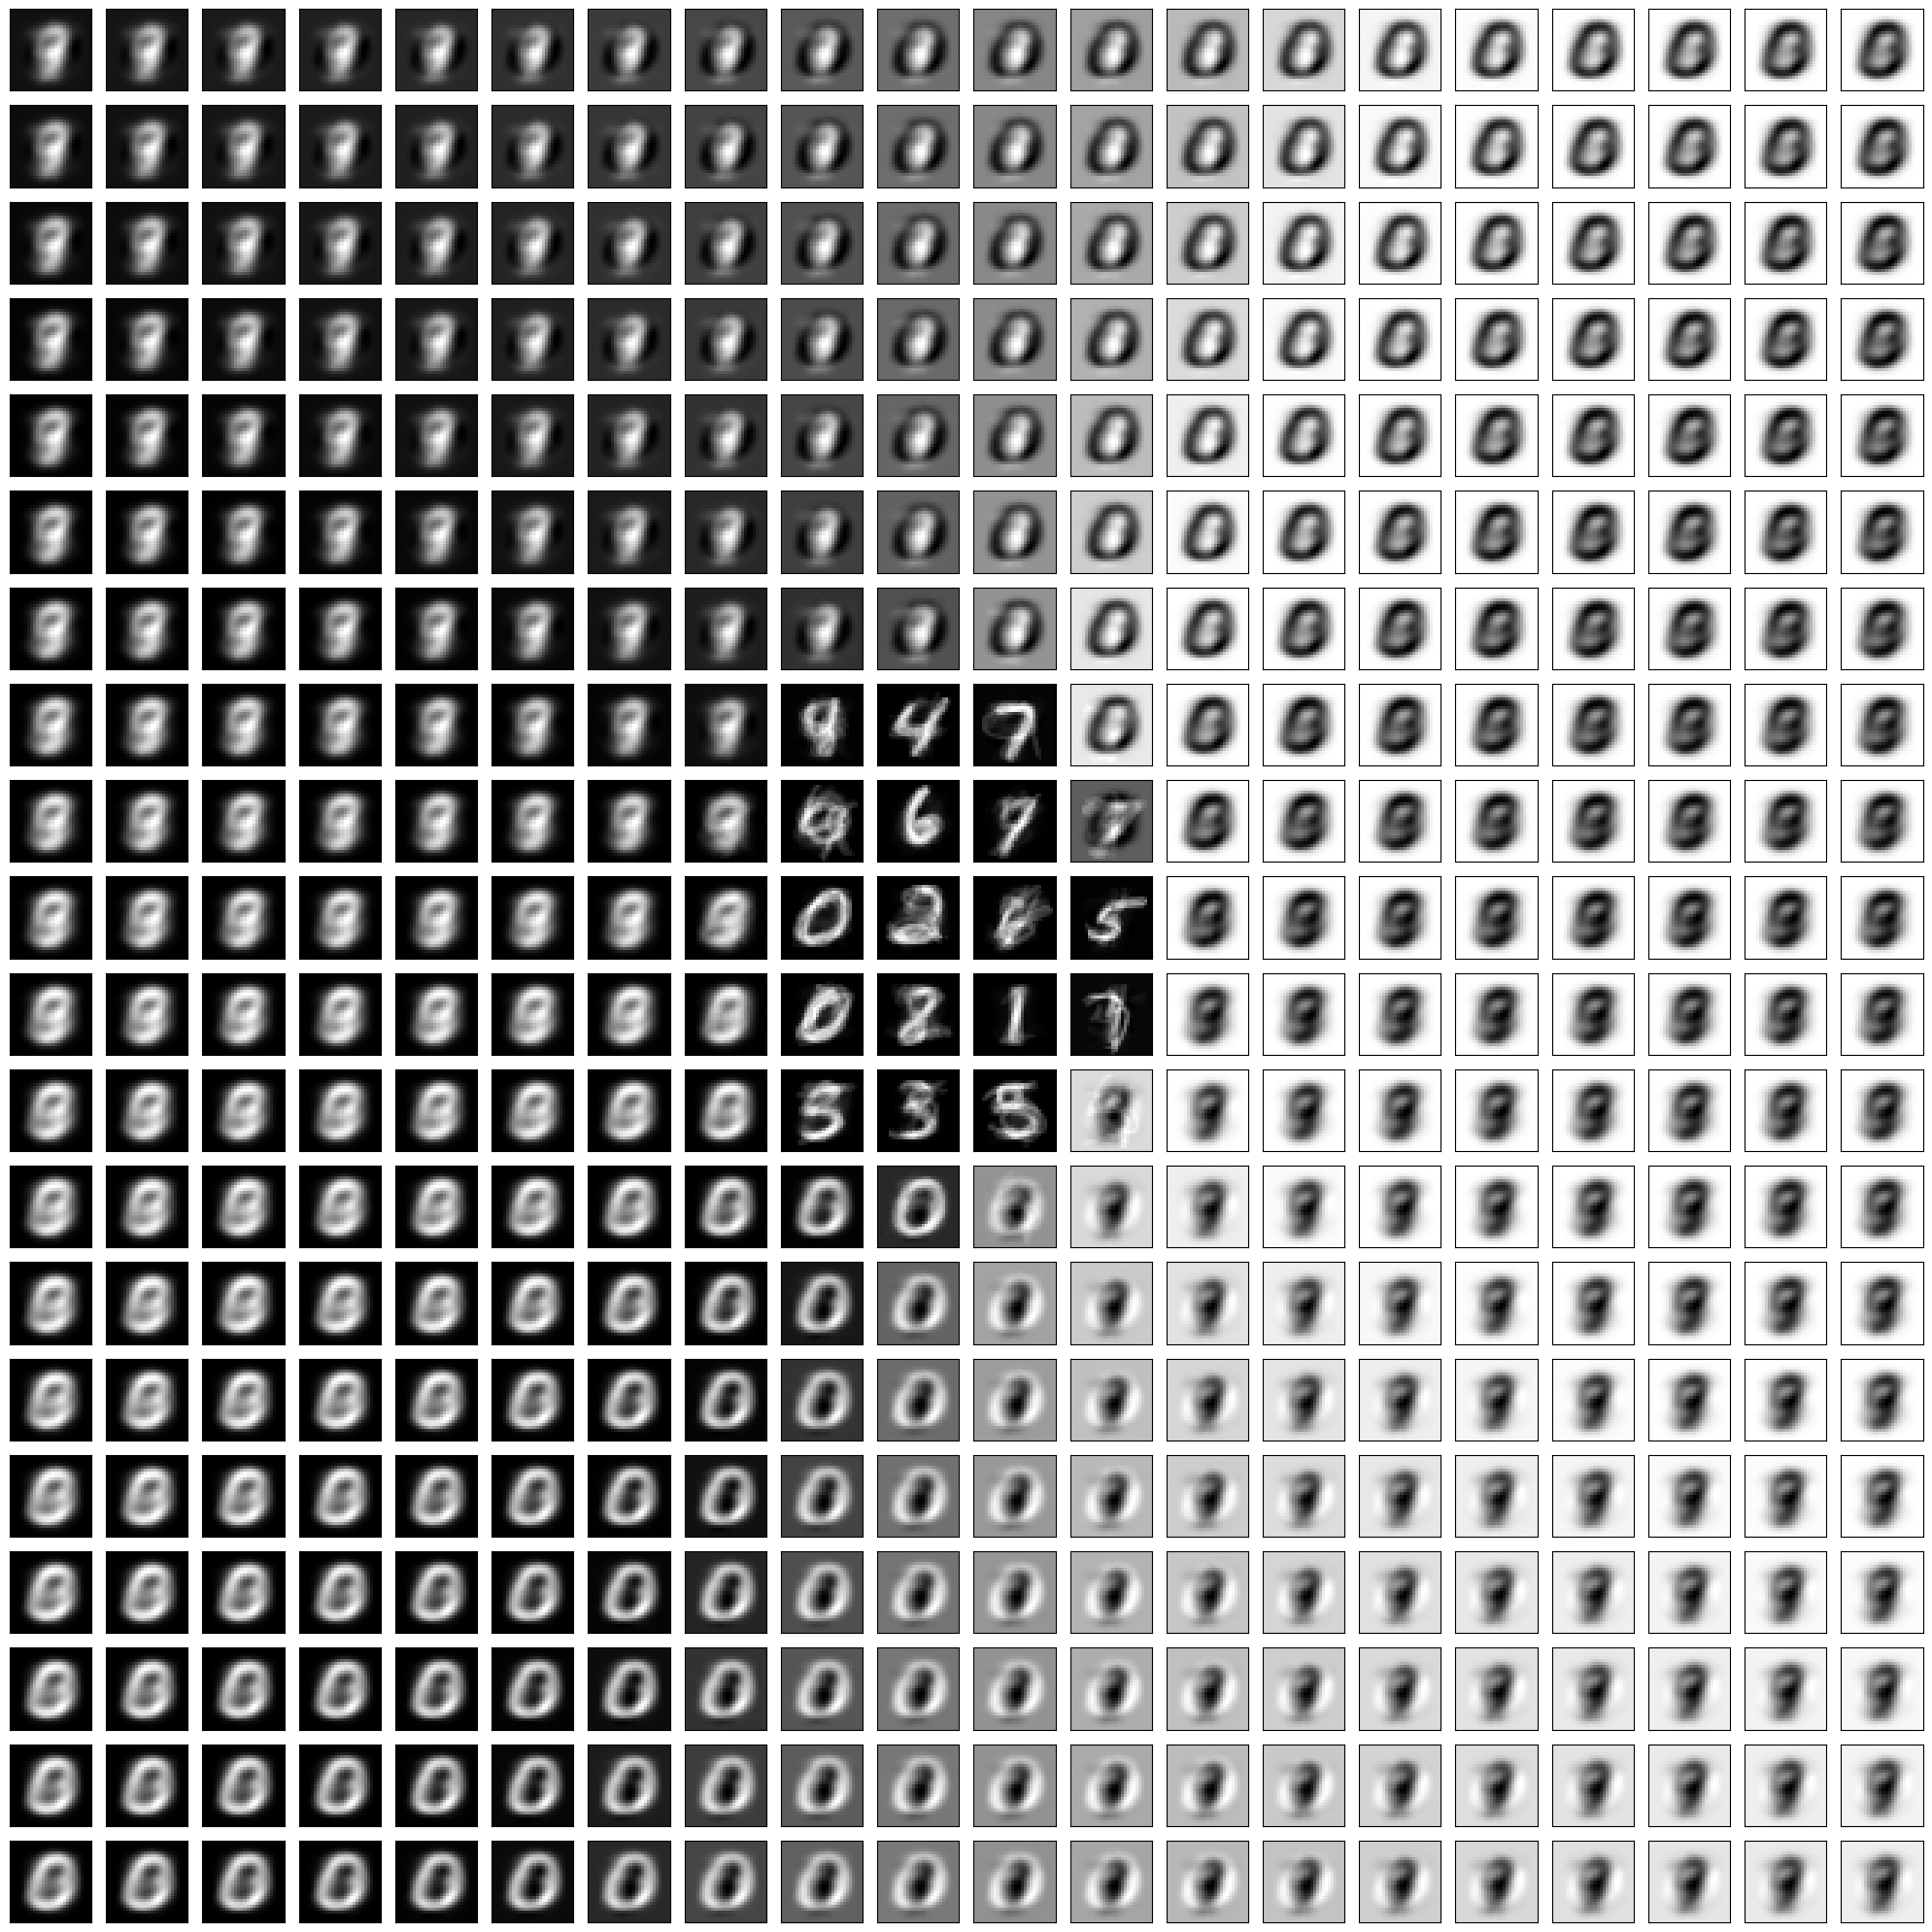

In [26]:
# SOM prototype images. Each cell shows the neurons weight vector
weights = som.get_weights()
fig, axes = plt.subplots(som_y, som_x, figsize=(som_x, som_y))
for i in range(som_x):
    for j in range(som_y):
        ax = axes[j, i]
        img = weights[i, j].reshape(28, 28)
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()

## SOM prototype grid
Many neurons show blurred prototypes that look like averaged or mixed digit strokes rather than a single well formed digit. In the central region several neurons display clear digit shapes (0, 1, 3, 4, 5, 6, 7). A large number of neurons appear to be showing 0.

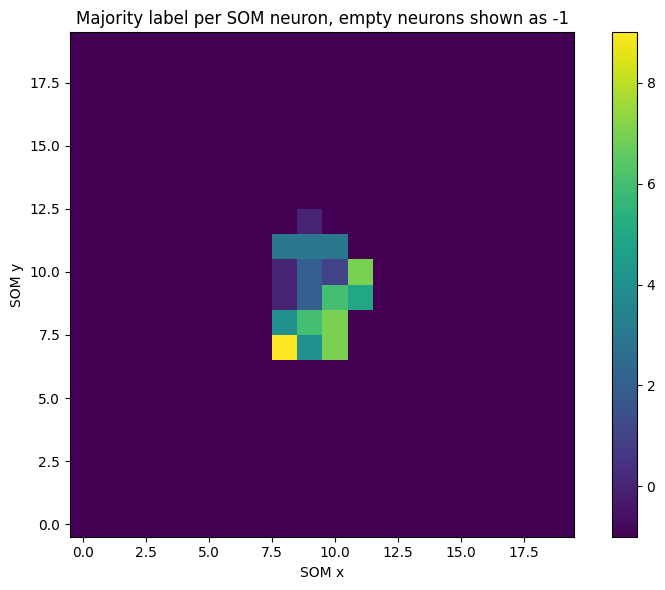

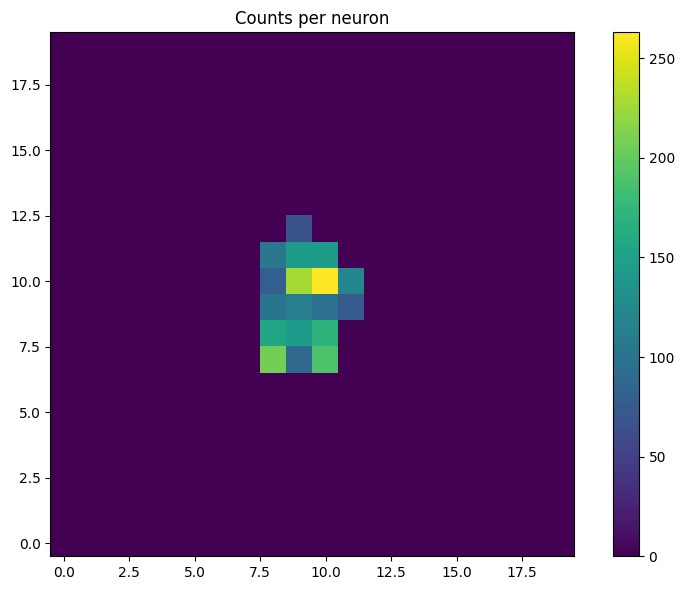

In [27]:
# Map each sample to its best matched unit and build label counts per neuron
label_counts = defaultdict(lambda: defaultdict(int))
winner_coords = []

for idx, x in enumerate(X_use):
    w = som.winner(x)
    winner_coords.append(w)
    if y_use is not None:
        label_counts[w][y_use[idx]] += 1

majority_label = np.full((som_x, som_y), fill_value=-1, dtype=object)
max_count = np.zeros((som_x, som_y), dtype=int)

# Determine majority label per neuron
if y_use is not None:
    for i in range(som_x):
        for j in range(som_y):
            counts = label_counts[(i, j)]
            if counts:
                lab = max(counts.items(), key=lambda kv: kv[1])[0]
                majority_label[i, j] = lab
                max_count[i, j] = sum(counts.values())
    
    unique_labels = sorted(list({l for d in label_counts.values() for l in d.keys()}))
    label_to_int = {lab: int(lab) for lab in unique_labels}
    int_map = np.full((som_x, som_y), -1)
    for i in range(som_x):
        for j in range(som_y):
            if majority_label[i, j] != -1:
                int_map[i, j] = label_to_int[majority_label[i, j]]

    plt.figure(figsize=(8,6))
    plt.title('Majority label per SOM neuron, empty neurons shown as -1')
    plt.imshow(int_map.T, origin='lower')
    plt.colorbar()
    plt.xlabel("SOM x")
    plt.ylabel("SOM y")
    plt.tight_layout()

    plt.figure(figsize=(8,6))
    plt.title('Counts per neuron')
    plt.imshow(max_count.T, origin='lower')
    plt.colorbar()
    plt.tight_layout()

## Majority-label map and Count per neuron figure
The first figure paints each SOM neuron by the digit class that most samples mapped to (empty neurons are shown as -1). The second image shows how many samples map to each neuron. The count per neuron shows how many samples map to each neuron.

Only a compact central region of neurons contains most of the mapped samples and majority labels. The rest of the grid is empty (-1). The SOM used only a small subset of neurons to represent the dataset. Meaning most input vectors found their best-matching units inside the central region.

Neuron (10, 10) count 263 majority label 1
Neuron (9, 10) count 228 majority label 2
Neuron (8, 7) count 207 majority label 9
Neuron (10, 7) count 190 majority label 7
Neuron (10, 8) count 170 majority label 7
Neuron (8, 8) count 156 majority label 4


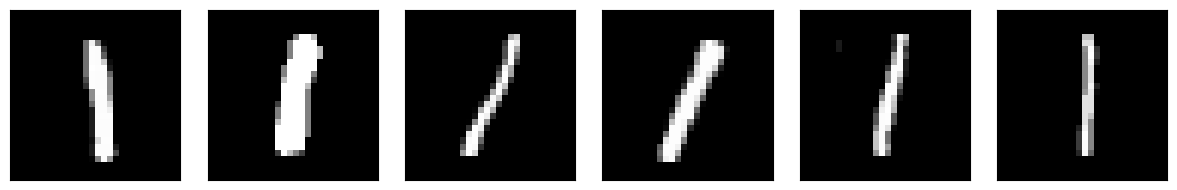

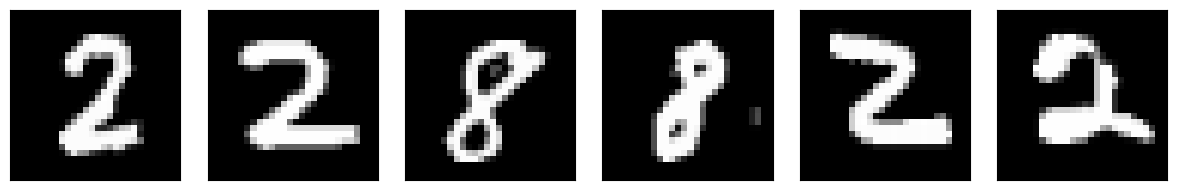

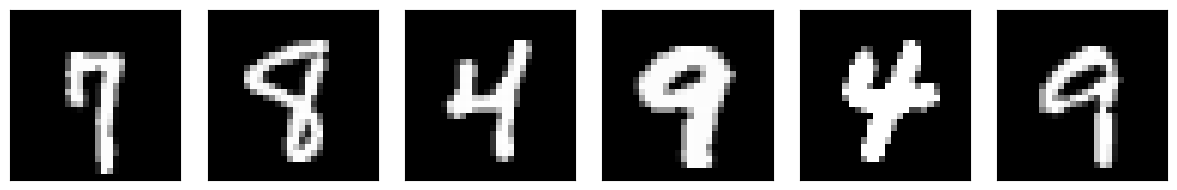

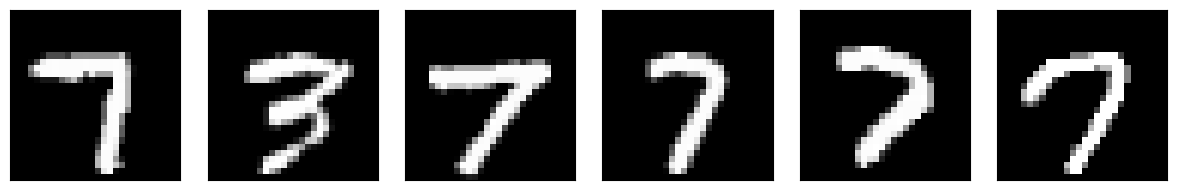

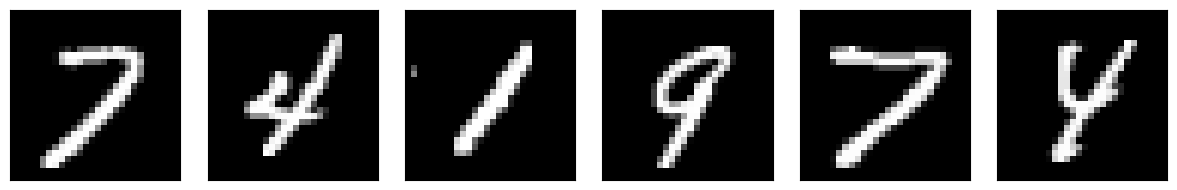

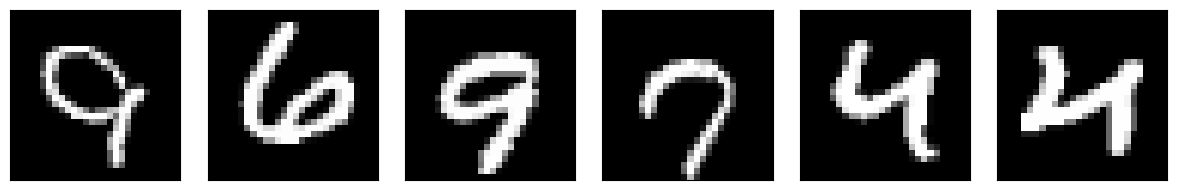

In [28]:
def show_examples_for_neuron(neuron_coord, n_examples=6):
    i, j = neuron_coord
    examples = []
    for idx, w in enumerate(winner_coords):
        if w == (i, j):
            examples.append(X_use[idx].reshape(28,28))

    examples = examples[:n_examples]
    fig, axes = plt.subplots(1, len(examples), figsize=(len(examples)*2, 2))
    for ax, ex in zip(axes, examples):
        ax.imshow(ex, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

# Find few neurons with many samples and show examples
flat = []
for i in range(som_x):
    for j in range(som_y):
        flat.append(((i,j), int(max_count[i,j])))
flat_sorted = sorted(flat, key=lambda kv: kv[1], reverse=True)
for coord, cnt in flat_sorted[:6]:
    print('Neuron', coord, 'count', cnt, 'majority label', majority_label[coord])
    show_examples_for_neuron(coord, n_examples=6)

## Neuron example inspection

In the figure there are six neurons with the highest hit counts and I inspected example images mapped to each neuron. Some neurons specialize strongly (neuron (10, 10)), while others are mixed and contain multiple digit classes. Mixed neurons are expected when prototypes sit between digit shapes, when handwriting is ambiguous or when the SOM's parameters cause averaging across classes.